In [7]:
import numpy as np
import os
import mne
import tensorflow
from tensorflow import keras

# EEGNet-specific imports
from keras import utils as np_utils
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Dense, Activation, Dropout
from keras.layers import Conv2D, AveragePooling2D
from keras.layers import SeparableConv2D, DepthwiseConv2D
from keras.layers import BatchNormalization
from keras.layers import SpatialDropout2D
from keras.layers import Input, Flatten
from keras.constraints import max_norm
from keras import backend as K


In [2]:
def EEGNet(nb_classes, Chans = 22, Samples = 128,
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta

    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.

    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 

    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.

    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)


In [3]:
folder_path_string = "/Users/Kai/Documents/Coding/Projekte/Exo Projekt Wiki GIT/Datensätze/BCICIV 2/a/BCICIV_2a_gdf/"

file_path_string = folder_path_string + "A01T.gdf"
evaluation_path_string = folder_path_string + "A01T.evt"

filenames = os.listdir(folder_path_string)
print(filenames)
raws = []
"""for filename in filenames:
    raws.append(mne.io.read_raw_gdf(folder_path_string + filename))

for raw in raws:
    raw.crop().load_data()
#raw = mne.io.read_raw_gdf(file_path_string)
#raw.crop().load_data()"""

['A01E.gdf', '.DS_Store', 'A01T.gdf', 'A07E.gdf', 'A06T.gdf', 'A07T.gdf', 'A06E.gdf', 'A08T.gdf', 'A05E.gdf', 'A04T.gdf', 'A09E.gdf', 'A08E.gdf', 'A05T.gdf', 'A04E.gdf', 'A09T.gdf', 'A02T.gdf', 'A03E.gdf', 'A02E.gdf', 'A03T.gdf']


'for filename in filenames:\n    raws.append(mne.io.read_raw_gdf(folder_path_string + filename))\n\nfor raw in raws:\n    raw.crop().load_data()\n#raw = mne.io.read_raw_gdf(file_path_string)\n#raw.crop().load_data()'

In [4]:
# set random seed
tensorflow.random.set_seed(1234)

# while the default tensorflow ordering is 'channels_last' we set it here
# to be explicit in case if the user has changed the default ordering
K.set_image_data_format('channels_last')

##################### Process, filter and epoch the data ######################
#data_path = sample.data_path()

# Set parameters and read data
#raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
raw_fname = file_path_string
#event_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'
event_fname = evaluation_path_string
tmin, tmax = -0., 1
#event_id = dict(aud_l=1, aud_r=2, vis_l=3, vis_r=4)
#event_id = dict(hand_left=1, hand_right=2, foot=3, tongue=4)

# Setup for reading the raw data
#raw = io.Raw(raw_fname, preload=True, verbose=False)
raw = mne.io.read_raw_gdf(raw_fname)
raw.load_data()
#original filter
raw.filter(2, None, method='iir')  # replace baselining with high-pass 
#raw.filter(2, None, method='fir')
events, event_ids = mne.events_from_annotations(raw)
#print("event_id ", event_id)
event_id = events[1]
print("event_id ",event_id)

#raw.info['bads'] = ['MEG 2443']  # set bad channels
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')

picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False)

# Read epochs
stims =[value for key, value in event_ids.items() if key in ('769','770','771','772')]
epochs = mne.Epochs(raw, events, stims, tmin, tmax, proj=False,
                    picks=picks, baseline=None, preload=True, verbose=False)
channels_to_remove = ['EOG-left', 'EOG-central', 'EOG-right']
epochs = epochs.drop_channels(channels_to_remove)
labels = epochs.events[:, -1]
print(epochs)

# extract raw data. scale by 1000 due to scaling sensitivity in deep learning
X = epochs.get_data()*1000 # format is in (trials, channels, samples)
y = labels
y[y == 7] = 0
y[y == 8] = 1
y[y == 9] = 2
y[y == 10] = 3

kernels, chans, samples = 1, X.shape[1], X.shape[2]

# take 50/25/25 percent of the data to train/validate/test

train_idx = round(X.shape[0] * 0.5)
test_idx = round(X.shape[0] * 0.75)

X_train      = X[0:train_idx,]
Y_train      = y[0:train_idx]
X_validate   = X[train_idx:test_idx,]
Y_validate   = y[train_idx:test_idx]
X_test       = X[test_idx:,]
Y_test       = y[test_idx:]

############################# EEGNet portion ##################################

# convert labels to one-hot encodings.
y_unique = np.unique(y)
num_classes = len(y_unique)
Y_train      = np_utils.to_categorical(Y_train-1, num_classes=num_classes)
Y_validate   = np_utils.to_categorical(Y_validate-1, num_classes=num_classes)
Y_test       = np_utils.to_categorical(Y_test-1, num_classes=num_classes)

# convert data to NHWC (trials, channels, samples, kernels) format. Data 
# contains 60 channels and 151 time-points. Set the number of kernels to 1.
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)

print("X.Shape", X.shape)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print("y.Shape", y.shape)
print('y_train shape:', Y_train.shape)
print('y_test shape:', Y_test.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

Extracting EDF parameters from /Users/Kai/Documents/Coding/Projekte/Exo Projekt Wiki GIT/Datensätze/BCICIV 2/a/BCICIV_2a_gdf/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 2 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 2.00 Hz: -6.02 dB

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
event_id  [0 0 3]
<Epochs |  288 events (all good), 0 - 1 sec, baseline off, ~12.2 MB, data loaded,
 '7': 72
 '8': 72
 '9': 72
 '10': 72>
X.Shape (288, 22, 251)
X_train shape: (144, 22, 251, 1)
X_test shape: (72, 22, 251, 1)
y.Shape (288,)
y_train shape: (144, 4)
y_test shape: (72, 4)
144 train samples
72 test samples


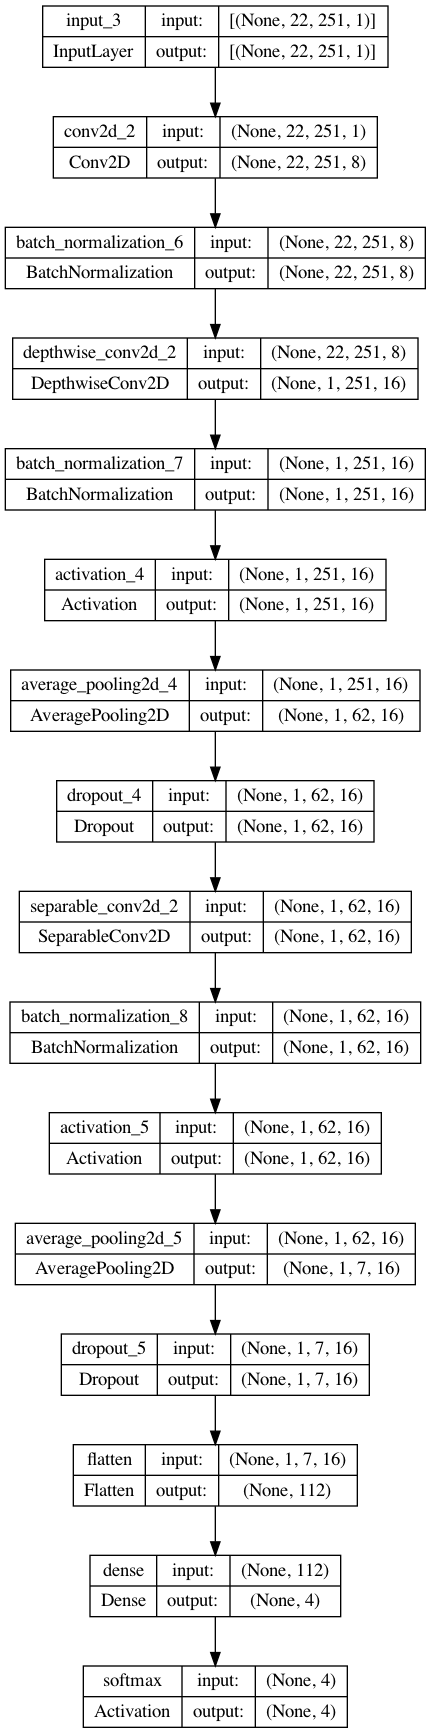

In [8]:
# configure the EEGNet-8,2,16 model with kernel length of 32 samples (other
# model configurations may do better, but this is a good starting point)
model = EEGNet(nb_classes = 4, Chans = 22, Samples = samples,
               dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16,
               dropoutType = 'Dropout')

# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics = ['accuracy', 'TruePositives', 'TrueNegatives'])

# count number of parameters in the model
numParams    = model.count_params()

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)

keras.utils.plot_model(model, show_shapes=True)

In [ ]:
fittedModel = model.fit(X_train, Y_train, batch_size = 16, epochs = 300,
                        verbose = 2, validation_data=(X_validate, Y_validate),
                        callbacks=[checkpointer])

# load optimal weights
model.load_weights('tmp/checkpoint.h5')

probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)
acc         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))